# ENSO_lifecycle: temporal evolution of SST anomalies in the central equatorial Pacific

Computes the temporal root mean square error (RMSE) of sea surface temperature anomalies (SSTA) in the Niño3.4 region (horizontal average over 5°S–5°N, 170°W–120°W) between model and observations. The analysis spans 6 years centred on ENSO peak years to evaluate the ability of the model to capture the full lifecycle of ENSO events, including onset, peak, and decay phases.

## Datasets Used for Temporal Evolution Comparison
The following reference datasets are employed to evaluate the ENSO lifecycle in model simulations:

- **TropFlux** (1979–2018): The primary dataset for comparison, offering accurate surface fluxes and anomalies for tropical climate studies.
  
## Additional datasets include:

- **20CRv2** (1871–2012): A historical reanalysis dataset reconstructing global atmospheric conditions using surface pressure observations.
- **ERA-Interim** (1979–2018): A widely used reanalysis product providing consistent, high-resolution estimates of atmospheric and surface variables.
- **ERSSTv5** (1854–2018): A globally gridded SST anomaly dataset optimised for long-term climate monitoring and ENSO analysis.
- **HadISST** (1870–2018): A comprehensive dataset of SST and sea ice, blending historical observations with reconstructions.
- **NCEP2** (1979–2018): A second-generation reanalysis dataset delivering improved global atmospheric and surface data.

## Dask Cluster 

Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46537,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37403,Total threads: 1
Dashboard: /proxy/37271/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38975,


2025-11-07 14:48:53,958 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('transpose-51796f45c94055336896fcaff921d265', 0, 0, 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: <Task ('transpose-51796f45c94055336896fcaff921d265', 0, 0, 0) transpose(..., ...)>
new run_spec: Alias(('transpose-51796f45c94055336896fcaff921d265', 0, 0, 0)->('absolute-reshape-transpose-51796f45c94055336896fcaff921d265', 0, 0, 0))
old dependencies: {('reshape-dc31e441449e388c75c0cf599d5342fb', 0, 0, 0)}
new dependencies: frozenset({('absolute-reshape-transpose-51796f45c94055336896fcaff921d265', 0, 0, 0)})

2025-11-07 14:48

## Datasets

In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-CM2": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-CM2",
    grid="gn"
),
## Note: It is possible to use tos (sea_surface_temperature; degC; ocean; mon) 
# "ACCESS-ESM1-5": 
#     Dataset(
#     short_name='tos',
#     project='CMIP6',
#     mip="Omon",
#     exp="historical",
#     ensemble="r1i1p1f1",
#     timerange="18500101/20190101",
#     dataset="ACCESS-ESM1-5",
#     grid="gn"
# )
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    timerange="19790101/20190101",
    type='reanaly',
    tier=2),
# "TROPFLUX":
#     Dataset(
#     short_name='tos',
#     dataset='TROPFLUX',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2),
}

## Add Ancillary files

In [4]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [5]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/esmvalcore/config/_config.py:59: ESMValCoreDeprecationWarning: Usage of extra facets located in ~/.esmvaltool/extra_facets has been deprecated in ESMValCore version 2.13.0 and is scheduled for removal in version 2.15.0. Please use the configuration option `extra_facets` instead (see https://github.com/ESMValGroup/ESMValCore/pull/2747 for details). To silent this warning and ignore deprecated extra facets, set the environment variable ESMVALTOOL_USE_NEW_EXTRA_FACETS_CONFIG=1.
  warn_if_old_extra_facets_exist()
(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/fx/sftlf/gn/v20191108/sftlf_fx_ACCESS-CM2_historical_r1i1p1f1_gn.nc)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/esmvalcore/config/_config.py:59: ESMValCoreDeprecationWarning: Usage of extra facets located in ~/.esmvaltool/extra_facets has been deprecated in ESMValCor

In [6]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import xarray as xr
from datetime import datetime

In [7]:
def sst_enso_n34(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = extract_region(cube, **nino34_latext_region)
    # remove time mean
    cube = anomalies(cube, period='monthly') 
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)##rolling window cuts off months?
    # cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5) #smooth once
    cube = area_statistics(cube,operator='mean')

    return cube

def sst_meridional(cube): ##along latitude for area
    nino34_latext_region = {"start_longitude": 160., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = mask_landsea(cube, mask_out="land")
    cube = anomalies(cube, period='monthly')
    cube = extract_region(cube, **nino34_latext_region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    # cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = meridional_statistics(cube,operator='mean')
    return cube

#rmse

In [8]:
model_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/iris/cube.py:4898: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/iris/cube.py:4898: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/iris/cube.py:4343: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/iris/cube.py:4898: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/iris/cube.py:4898: IrisIgnoringBoundsWar

## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the main differences between the model and the reference.

In [9]:
from iris.util import rolling_window

def sst_regressed(n34_cube): 
    """Regression function for sst_time_series on sst_enso."""
    n34_dec = extract_month(n34_cube, 12)
    # 6 year epoch: [yr-2, yr-1, yr, yr+1, yr+2, yr+3] with monthly data (12) #exclude first year
    n34_sel = rolling_window(n34_cube[12:].data, window=6*12, step=12, axis=-1) #axis only time - 1d
    
    # 1) linear regression of sst_time_series on sst_enso
    # not first 2 or last 3 years for epochs # also exclude first year, leadlagyr=3
    b_data = n34_dec[3:-3].data
    b_with_intercept = np.vstack([b_data, np.ones_like(b_data)]).T    
    print(n34_sel.shape, b_with_intercept.shape)
    coefs, _, _, _ = np.linalg.lstsq(b_with_intercept, n34_sel, rcond=None)
    
    return coefs[0]


In [10]:
model_n34 = model_datasets_prep1["ACCESS-CM2"]
model_n34_area = model_datasets_prep2["ACCESS-CM2"]

obs_n34 = obs_datasets_prep1["HadISST"]
obs_n34_area = obs_datasets_prep2["HadISST"]

In [11]:
print(datetime.now())
## metric computation - rmse of slopes

model = sst_regressed(model_n34)
print(datetime.now())

obs = sst_regressed(obs_n34)
print(datetime.now())

rmse = np.sqrt(np.mean((obs - model) ** 2))
rmse

2025-11-07 14:48:16.138995
(108, 72) (108, 2)
2025-11-07 14:48:48.604206
(29, 72) (29, 2)
2025-11-07 14:48:57.139783


0.25952134

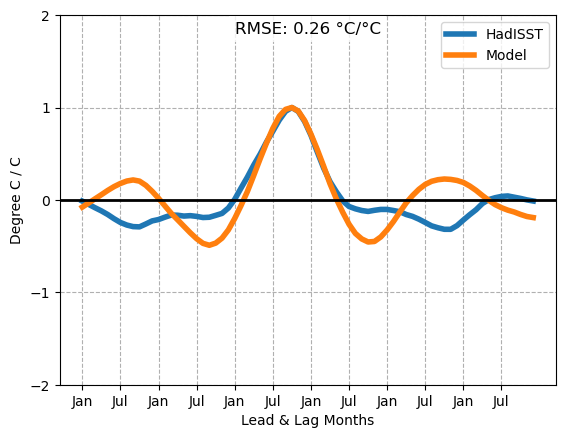

In [12]:
months = np.arange(1, 73) - 36

# Plot the slope
plt.plot(months, obs, label='HadISST', lw=4)
plt.plot(months, model, label='Model', lw=4)

# Draw a black dashed line at y=0.25
# plt.axhline(y=0.25, color='black', linestyle='--', label='0.25 threshold')

# Draw a thicker line at y=0
plt.axhline(y=0, color='black', linewidth=2) #, label='Zero Line')

# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)

# Set the labels and titles
plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C / C')
plt.legend()
plt.grid(linestyle='--')

# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)
plt.yticks(np.arange(-2,2.5, step=1))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} °C/°C', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
# Show the plot
plt.show()

Figure 1: Temporal evolution of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), illustrating the ENSO-associated variability. The model tends to exhibit overly frequent transitions between negative and positive SSTA phases. The black curve represents the reference data, while the blue curve corresponds to the model output. The derived metric is the temporal root mean square error (RMSE) between the model and reference curves.

# Diagnostic Level 2

The second level shows the broader picture to better understand the spatial-temporal pattern of ENSO: the Hovmöller of the anomalies in the equatorial Pacific.

In [13]:

def sst_regressed_2d(n34_area, n34):
    """Regression function for sst_time_series area on sst_enso."""
    n34_dec = extract_month(n34, 12)
    # 6 year epoch: [yr-2, yr-1, yr, yr+1, yr+2, yr+3] 
    n34area_sel = rolling_window(n34_area[12:].data, window=6*12, step=12, axis=0)
    print(n34_area.summary(shorten=True), n34area_sel.shape)
    
    #2 area linear regression
    b_data = n34_dec[3:-3].data
    b_with_intercept = np.vstack([b_data, np.ones_like(b_data)]).T

    a_data = n34area_sel.reshape(n34area_sel.shape[0], -1)
    
    print(n34area_sel.shape, a_data.shape, b_data.shape)
    coefs_area, _, _, _ = np.linalg.lstsq(b_with_intercept, a_data, rcond=None)
    slope_area = coefs_area[0].reshape(n34area_sel.shape[1], n34area_sel.shape[2])
    
    return slope_area


In [14]:
print(datetime.now())

model_area = sst_regressed_2d(model_n34_area, model_n34)
print(model_area.shape, datetime.now())

obs_area = sst_regressed_2d(obs_n34_area, obs_n34)
print(obs_area.shape,datetime.now())

2025-11-07 14:48:57.415621
surface_temperature / (degC)        (time: 1376; longitude: 360) (108, 72, 360)
(108, 72, 360) (108, 25920) (108,)
(72, 360) 2025-11-07 14:49:20.502409
surface_temperature / (degC)        (time: 428; longitude: 360) (29, 72, 360)
(29, 72, 360) (29, 25920) (29,)
(72, 360) 2025-11-07 14:49:29.969995


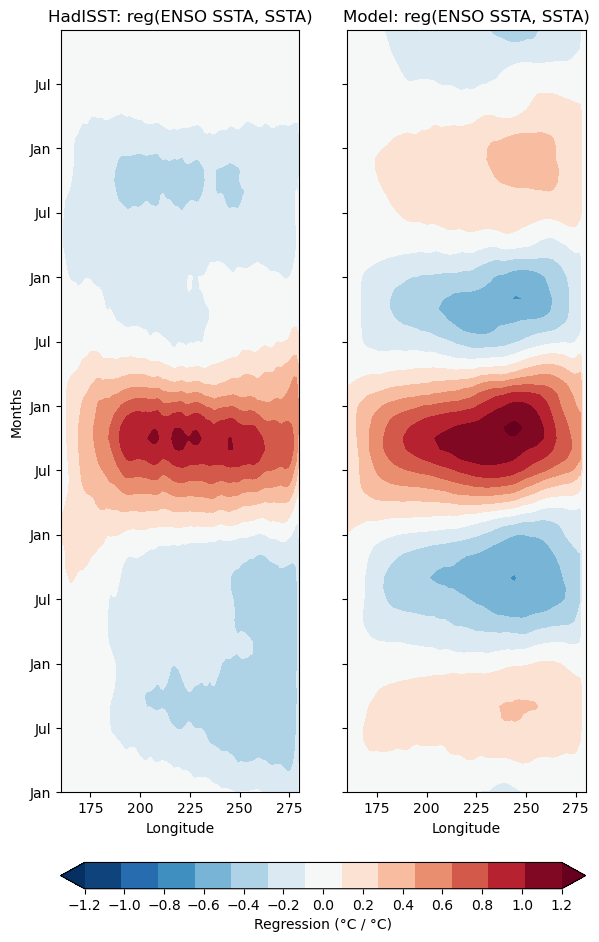

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom ticks for the y-axis (every 6 months)
yticks = range(1, 73, 6)
ytick_labels = ['Jan', 'Jul'] * (len(yticks) // 2)

# Define shared color limits and colorbar ticks
vmin = -1.2
vmax = 1.2
ticks = np.arange(vmin, vmax + 0.2, 0.2)  # Ticks from -1.2 to 1.2 at intervals of 0.2

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12), sharey=True)

# First subplot: HadISST
c1 = ax1.contourf(
    obs_n34_area.coord('longitude').points,
    range(1, 73),
    obs_area, #area
    levels=np.linspace(vmin, vmax, 14),
    cmap='RdBu_r',
    extend='both'  # Allow for values beyond vmin and vmax
)
ax1.set_ylabel('Months')
ax1.set_xlabel('Longitude')
ax1.set_xlim([160, 280])
ax1.set_title('HadISST: reg(ENSO SSTA, SSTA)')
ax1.set_yticks(yticks)
ax1.set_yticklabels(ytick_labels)

# Second subplot: Model
c2 = ax2.contourf(
    model_n34_area.coord('longitude').points,
    range(1, 73),
    model_area,
    levels=np.linspace(vmin, vmax, 14),
    cmap='RdBu_r',
    extend='both'  # Allow for values beyond vmin and vmax
)
ax2.set_xlabel('Longitude')
ax2.set_title('Model: reg(ENSO SSTA, SSTA)')
ax2.set_xlim([160, 280])

# Adjust the layout to add space for the colorbar
fig.subplots_adjust(bottom=0.15, right=1.0)  # Adjust bottom margin to fit colorbar

# Add a horizontal colorbar beneath the subplots
cbar = fig.colorbar(c1, ax=[ax1, ax2], label='Regression (°C / °C)', orientation='horizontal', ticks=ticks, fraction=0.05, pad=0.08)

# Display the plot
plt.show()


Figure 2: spatial-temporal structure of sea surface temperature anomalies (SSTA) associated with ENSO in the equatorial Pacific (5°S-5°N average), showing usually the too frequent swing from negative to positive SSTA, along with maximum anomalies during ENSO peak lasting too long. The left and right Hovmöllers show respectively the reference and the model.

## Diagnostic level 3

In [16]:
from esmvalcore.preprocessor import (
                        mask_above_threshold, mask_below_threshold,
)
import numpy as np

def mask_to_years(events):
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]

def enso_events(cube): # get cube years min/max, remove 3:-3
    datayears = [cube.coord('time').units.num2date(time).year for time in cube.coord('time').points]
    indexmap = {yr: index for index, yr in enumerate(datayears[3:-3])}
    
    cb_std = cube.data.std()
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.5*cb_std))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.5*cb_std))
    
    events = {'la nina':[indexmap[nyr] for nyr in a_events if nyr in datayears[3:-3]],
              'el nino':[indexmap[nyr] for nyr in o_events if nyr in datayears[3:-3]]}
    return events


months = np.arange(1, 73) - 36

def enso_composite_plot(model_n34, label, line):
    n34_dec = extract_month(model_n34, 12)
    events = enso_events(n34_dec)
    
    n34_sel = rolling_window(model_n34[12:].data, window=6*12, step=12, axis=-1) 
    colors = {'la nina':'blue', 'el nino':'red'}
    for enso, yr_indices in events.items():
        arr = n34_sel[yr_indices]
        
        # No regression, mean enso epoch
        mean = np.mean(arr, axis=0)
        print(model_n34.shape, "array shape:", arr.shape)

        plt.plot(months, mean, label=f'{enso} {label}', linestyle=line, color=colors[enso], lw=3)

    return


2025-11-07 14:49:30.438157 start
(1376,) array shape: (33, 72)
(1376,) array shape: (33, 72)
(428,) array shape: (12, 72)
(428,) array shape: (10, 72)
2025-11-07 14:50:07.148509 composite done


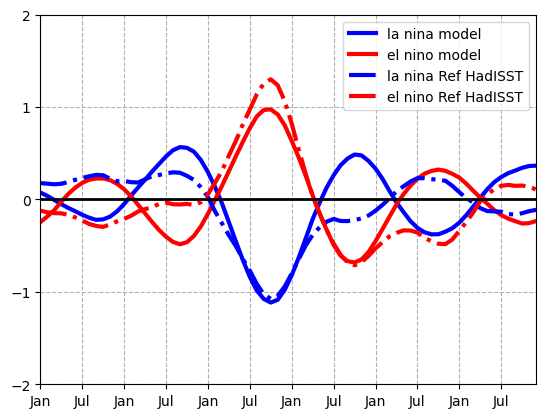

In [17]:
#plot model and obs
print(datetime.now(), "start")
enso_composite_plot(model_n34, 'model', 'solid')
enso_composite_plot(obs_n34, 'Ref HadISST', 'dashdot')
print(datetime.now(), "composite done")
plt.axhline(y=0, color='black', linewidth=2)

xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)
plt.xticks(xticks, xtick_labels)
plt.xlim(-35,36)
plt.grid(linestyle='--')
plt.yticks(np.arange(-2,2.5, step=1))
plt.legend()
plt.show()

**Figure 3**: temporal structure of sea surface temperature anomalies (SSTA) during La Niña and El Niño in the central equatorial Pacific (Niño3.4 averaged), showing usually the model's tendency to swing from El Niño to La Niña and the weak (of not frequent enough) capacity of the models to generate two-years La Niña. The blue and red curves show respectively La Niña composite and the El Niño composite, dashed and solid lines show respectively the reference and the model.

## Diagnostic level 4

In [18]:
def enso_composite_plot4(n34_cube, n34_area, label, i, axes):
    n34_dec = extract_month(n34_cube, 12)
    events = enso_events(n34_dec)
    # exclude first year
    n34area_sel = rolling_window(n34_area[12:].data, window=6*12, step=12, axis=0) # axis 0 time
    print(n34_area.summary(shorten=True), n34area_sel.shape)
    
    for enso, yr_indices in events.items():
        print(f'{len(yr_indices)} years, cube meri:{n34_area.shape}')
        # plot area, use indices to select years from rolling window
        arr = n34area_sel[yr_indices] # 33, 25, 72 (33, 72, 360)
        a_data = arr.reshape(arr.shape[0], -1) 
        print(f"selected years{arr.shape}, data for means{a_data.shape}")
        
        means = np.mean(a_data, axis=0)
        means = means.reshape(arr.shape[1], arr.shape[2])
        cplot = plot_ssta(axes[enso], n34_area.coord('longitude'), means, f'{enso} {label}', i)
        
    return cplot

# subplot each regression data
def plot_ssta(ax, area_coordlon, ssta, label, i):
    vmin = -1.2
    vmax = 1.2
    c1 = ax[i].contourf( # Length of x (360) must match number of columns in z (72)
        area_coordlon.points,
        range(1, 73),
        ssta,
        levels=np.linspace(vmin, vmax, 14),
        cmap='RdBu_r',
        extend='both'  # Allow for values beyond vmin and vmax
    )
    ax[i].set_ylabel('Months')
    ax[i].set_xlabel('Longitude')
    ax[i].set_xlim([160,280])
    ax[i].set_title(f'{label}: reg SSTA')
    ax[i].set_yticks(range(1, 73, 6))
    ax[i].set_yticklabels(['Jan', 'Jul'] * (len(yticks) // 2))
    return c1
    

2025-11-07 14:50:07.921085 start
surface_temperature / (degC)        (time: 1376; longitude: 360) (108, 72, 360)
33 years, cube meri:(1376, 360)
selected years(33, 72, 360), data for means(33, 25920)
33 years, cube meri:(1376, 360)
selected years(33, 72, 360), data for means(33, 25920)
surface_temperature / (degC)        (time: 428; longitude: 360) (29, 72, 360)
12 years, cube meri:(428, 360)
selected years(12, 72, 360), data for means(12, 25920)
10 years, cube meri:(428, 360)
selected years(10, 72, 360), data for means(10, 25920)
2025-11-07 14:50:41.414742 done


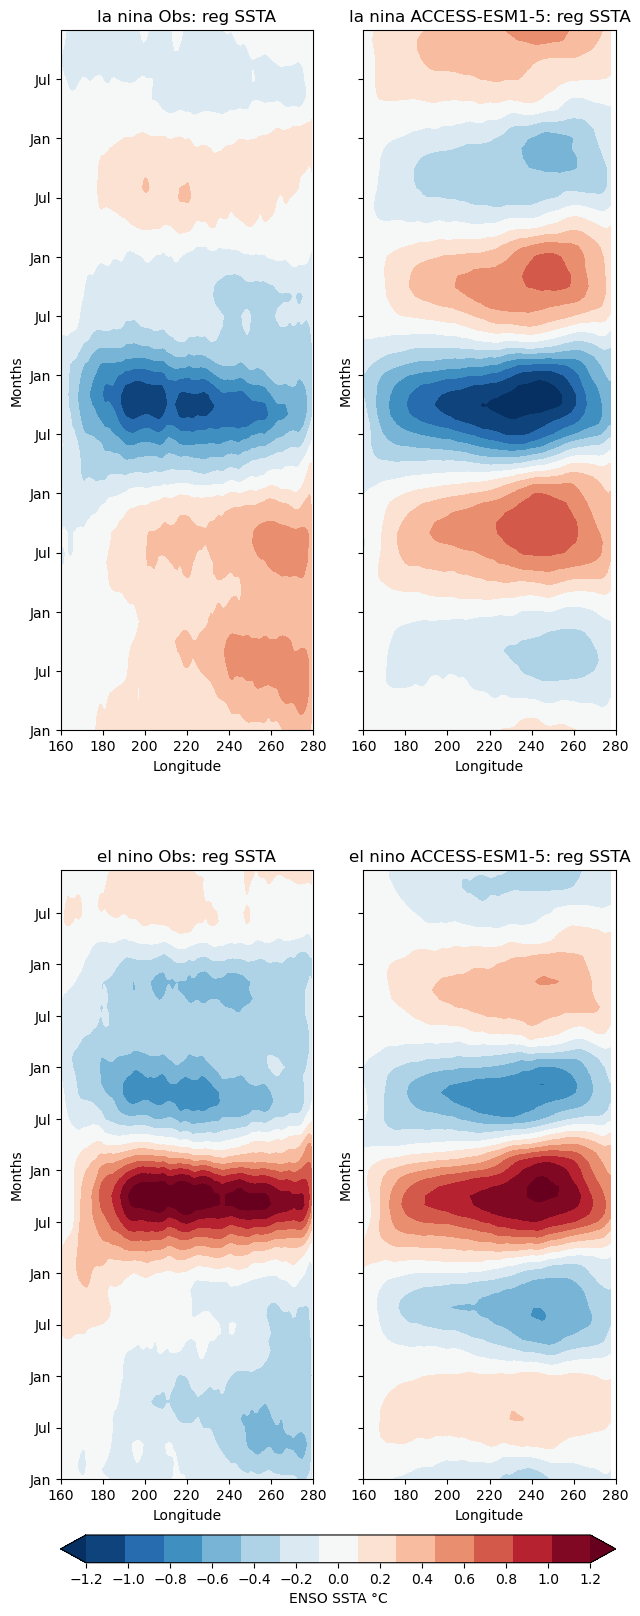

In [19]:
# Create the subplots

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(6, 20), sharey=True)
# # layout rows la nina ax1, el nino ax2 for datasets 0,1
axes_rows = {'la nina':ax1, 'el nino':ax2}
print(datetime.now(), "start")
c1 = enso_composite_plot4(model_n34, model_n34_area, 'ACCESS-ESM1-5', 1, axes_rows) 
# obs
c1 = enso_composite_plot4(obs_n34, obs_n34_area, 'Obs', 0, axes_rows)
print(datetime.now(), "done")

# Adjust the layout to add more space for the colorbar on the right
plt.subplots_adjust(right=1.05)

cbar = fig.colorbar(c1, ax=[ax2[0], ax2[1]], label='ENSO SSTA °C', orientation='horizontal', 
                    ticks=np.arange(vmin, vmax + 0.2, 0.2), fraction=0.05, pad=0.08)

Figure 4: spatial-temporal structure of sea surface temperature anomalies (SSTA) during La Niña and El Niño in the equatorial Pacific (5°S-5°N average), showing usually the model's tendency to swing from El Niño to La Niña and the weak (of not frequent enough) capacity of the models to generate two-years La Niña. The left and right Hovmöllers show respectively the reference and the model. The first and second rows show respectively the La Niña composites and the El Niño composites.

In [21]:
client.close()